In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm
from xgboost import XGBClassifier
from xgboost import plot_importance
# from sklearn import feature_selection
# from collections import Counter
# from imblearn.combine import SMOTEENN

In [42]:
train = pd.read_excel('附件1语音业务用户满意度数据.xlsx')
test = pd.read_excel('附件3语音业务用户满意度预测数据.xlsx')
# 按附件五说明处理缺失
train.是否关怀用户.fillna('否',inplace=True)
train.是否去过营业厅.fillna('否',inplace=True)
train.drop(['重定向次数','重定向驻留时长','其他，请注明','用户描述','其他，请注明.1','用户描述.1','用户id'],
            axis=1, inplace=True)
train.drop(train[train.是否5G网络客户.isnull()].index,axis=0,inplace=True)
train.外省流量占比.fillna(train.外省流量占比.median(),inplace=True)
train = train.reset_index(drop=True)

target = train.iloc[:,0:4]
train = train.iloc[:,4:]
test.drop(['用户id', '性别', '是否不限量套餐到达用户'],axis=1,inplace=True)

In [43]:
reindex_col = [
       '居民小区', '办公室', '高校', '商业街', '地铁', '农村', '高铁', '手机没有信号', '有信号无法拨通',
       '通话过程中突然中断', '通话中有杂音、听不清、断断续续', '串线', '通话过程中一方听不见']
for col in reindex_col:
       train[col] = train[col].apply(lambda x: 0 if x==-1 else 1)
       
train['4\\5G用户'] = train['4\\5G用户'].apply(lambda x: 0 if x=='2G' else 1 if x=='4G' else 2)

train.loc[train[train['语音方式']=='VoLTE'].index, '语音方式']='VOLTE'

reindex_col=['是否关怀用户','是否4G网络客户（本地剔除物联网）', '是否5G网络客户','是否去过营业厅','是否实名登记用户']
for col in reindex_col:
    train[col] = train[col].apply(lambda x: 1 if x=='是' else 0 if x=='否' else x)

# 将终端品牌分为苹果，华为，小米和其他
name=['苹果','华为','小米科技']

train['终端品牌']=train['终端品牌'].apply(lambda x: '其他' if x not in name else x)
train.drop('终端品牌类型',axis=1, inplace=True)

# 查阅北京移动客户分级相关资料，客户星级重分类为（未评级准星一星二星）/（三星）/（银卡）/(金卡，白金卡，钻石卡)
def reindex(x):
    c1=['未评级','准星','一星','二星']
    c2=['三星']
    c3=['银卡']
    c4=['金卡','白金卡','钻石卡']
    if x in c1:
        x=1
    elif x in c2:
        x=2
    elif x in c3:
        x=3
    elif x in c4:
        x=4
    else:
        x
    return x

train['客户星级标识']=train['客户星级标识'].apply(reindex)

train.shape

(5428, 43)

In [44]:
reindex_col = [
       '居民小区', '办公室', '高校', '商业街', '地铁', '农村', '高铁', '手机没有信号', '有信号无法拨通',
       '通话过程中突然中断', '通话中有杂音、听不清、断断续续', '串线', '通话过程中一方听不见']
for col in reindex_col:
       test[col] = test[col].apply(lambda x: 0 if x==-1 else 1)
       
test['4\\5G用户'] = test['4\\5G用户'].apply(lambda x: 0 if x=='2G' else 1 if x=='4G' else 2)

reindex_col=['是否关怀用户','是否4G网络客户（本地剔除物联网）', '是否5G网络客户']
for col in reindex_col:
    test[col] = test[col].apply(lambda x: 1 if x=='是' else 0 if x=='否' else x)

# 将终端品牌分为苹果，华为，小米和其他
name=['苹果','华为','小米科技']
test['终端品牌']=test['终端品牌'].apply(lambda x: '其他' if x not in name else x)
test.drop('终端品牌类型',axis=1, inplace=True)

# 查阅北京移动客户分级相关资料，客户星级重分类为（未评级准星一星二星）/（三星）/（银卡）/(金卡，白金卡，钻石卡)
def reindex(x):
    c1=['未评级','准星','一星','二星']
    c2=['三星']
    c3=['银卡']
    c4=['金卡','白金卡','钻石卡']
    if x in c1:
        x=1
    elif x in c2:
        x=2
    elif x in c3:
        x=3
    elif x in c4:
        x=4
    else:
        x
    return x

test['客户星级标识']=test['客户星级标识'].apply(reindex)

test.shape


(2599, 40)

In [45]:
# train
loss_times_cols = ['脱网次数','mos质差次数', '未接通掉话次数']
numcols = ['套外流量（MB）','套外流量费（元）', '外省语音占比', '外省流量占比','语音通话-时长（分钟）', '省际漫游-时长（分钟）',
'ARPU（家庭宽带）','当月ARPU', '当月MOU', '前3月ARPU', '前3月MOU',
'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）','当月欠费金额', '前第3个月欠费金额']

for i in numcols:
    mean_col=train[i].mean()
    std_col=train[i].std()
    train.loc[train[train[i]>mean_col+3*std_col].index,i]=mean_col+3*std_col

# k均值聚类三个次数列
kdis = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
for col in loss_times_cols:
    train[col] = kdis.fit_transform(train[col].values.reshape(-1,1))

# 独热编码语音方式和终端品牌
ohc_list = ['语音方式','终端品牌']
ohc = preprocessing.OneHotEncoder(drop='if_binary')
a = pd.DataFrame(ohc.fit_transform(train[ohc_list]).toarray(), columns=ohc.get_feature_names_out())
train = pd.concat([train, a], axis=1)
train = train.drop(ohc_list,axis=1) 

In [46]:
# test
loss_times_cols = ['脱网次数','mos质差次数', '未接通掉话次数']
numcols = ['套外流量（MB）','套外流量费（元）', '外省语音占比', '外省流量占比','语音通话-时长（分钟）', '省际漫游-时长（分钟）',
'当月ARPU', '当月MOU', '前3月ARPU', '前3月MOU',
'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）']

# 15个数值变量中大多数为0，存在异常值且差异极大，但是通话时长较长或者上网较多的用户，更能够从中发现问题，
# 考虑采用截尾方法处理，将大于$\mu+3\sigma$的数据标记为截尾,替换相应数值。
for i in numcols:
    mean_col=test[i].mean()
    std_col=test[i].std()
    test.loc[test[test[i]>mean_col+3*std_col].index,i]=mean_col+3*std_col

# k均值聚类三个次数列
kdis = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
for col in loss_times_cols:
    test[col] = kdis.fit_transform(test[col].values.reshape(-1,1))

# 独热编码语音方式和终端品牌
ohc_list = ['终端品牌']
ohc = preprocessing.OneHotEncoder(drop='if_binary')
a = pd.DataFrame(ohc.fit_transform(test[ohc_list]).toarray(), columns=ohc.get_feature_names_out())
test = pd.concat([test, a], axis=1)
test = test.drop(ohc_list,axis=1)

- BaseLine

In [47]:
# 切分训练和验证集
x_train,x_vali,y_train,y_vali = train_test_split(train, target.iloc[:,3],test_size=0.3)
for i in range(4):
    rfc = RandomForestClassifier(oob_score=True,random_state=0)
    rfc.fit(x_train, y_train)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train))*100)
    print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)

第0次测试：
Training Accuracy :  100.0
Validation Accuracy :  51.56537753222836
out-of-bagging Accuracy: 50.697551987365095
第1次测试：
Training Accuracy :  100.0
Validation Accuracy :  51.56537753222836
out-of-bagging Accuracy: 50.697551987365095
第2次测试：
Training Accuracy :  100.0
Validation Accuracy :  51.56537753222836
out-of-bagging Accuracy: 50.697551987365095
第3次测试：
Training Accuracy :  100.0
Validation Accuracy :  51.56537753222836
out-of-bagging Accuracy: 50.697551987365095


Text(0.5, 0, 'Random Forest Feature Importance')

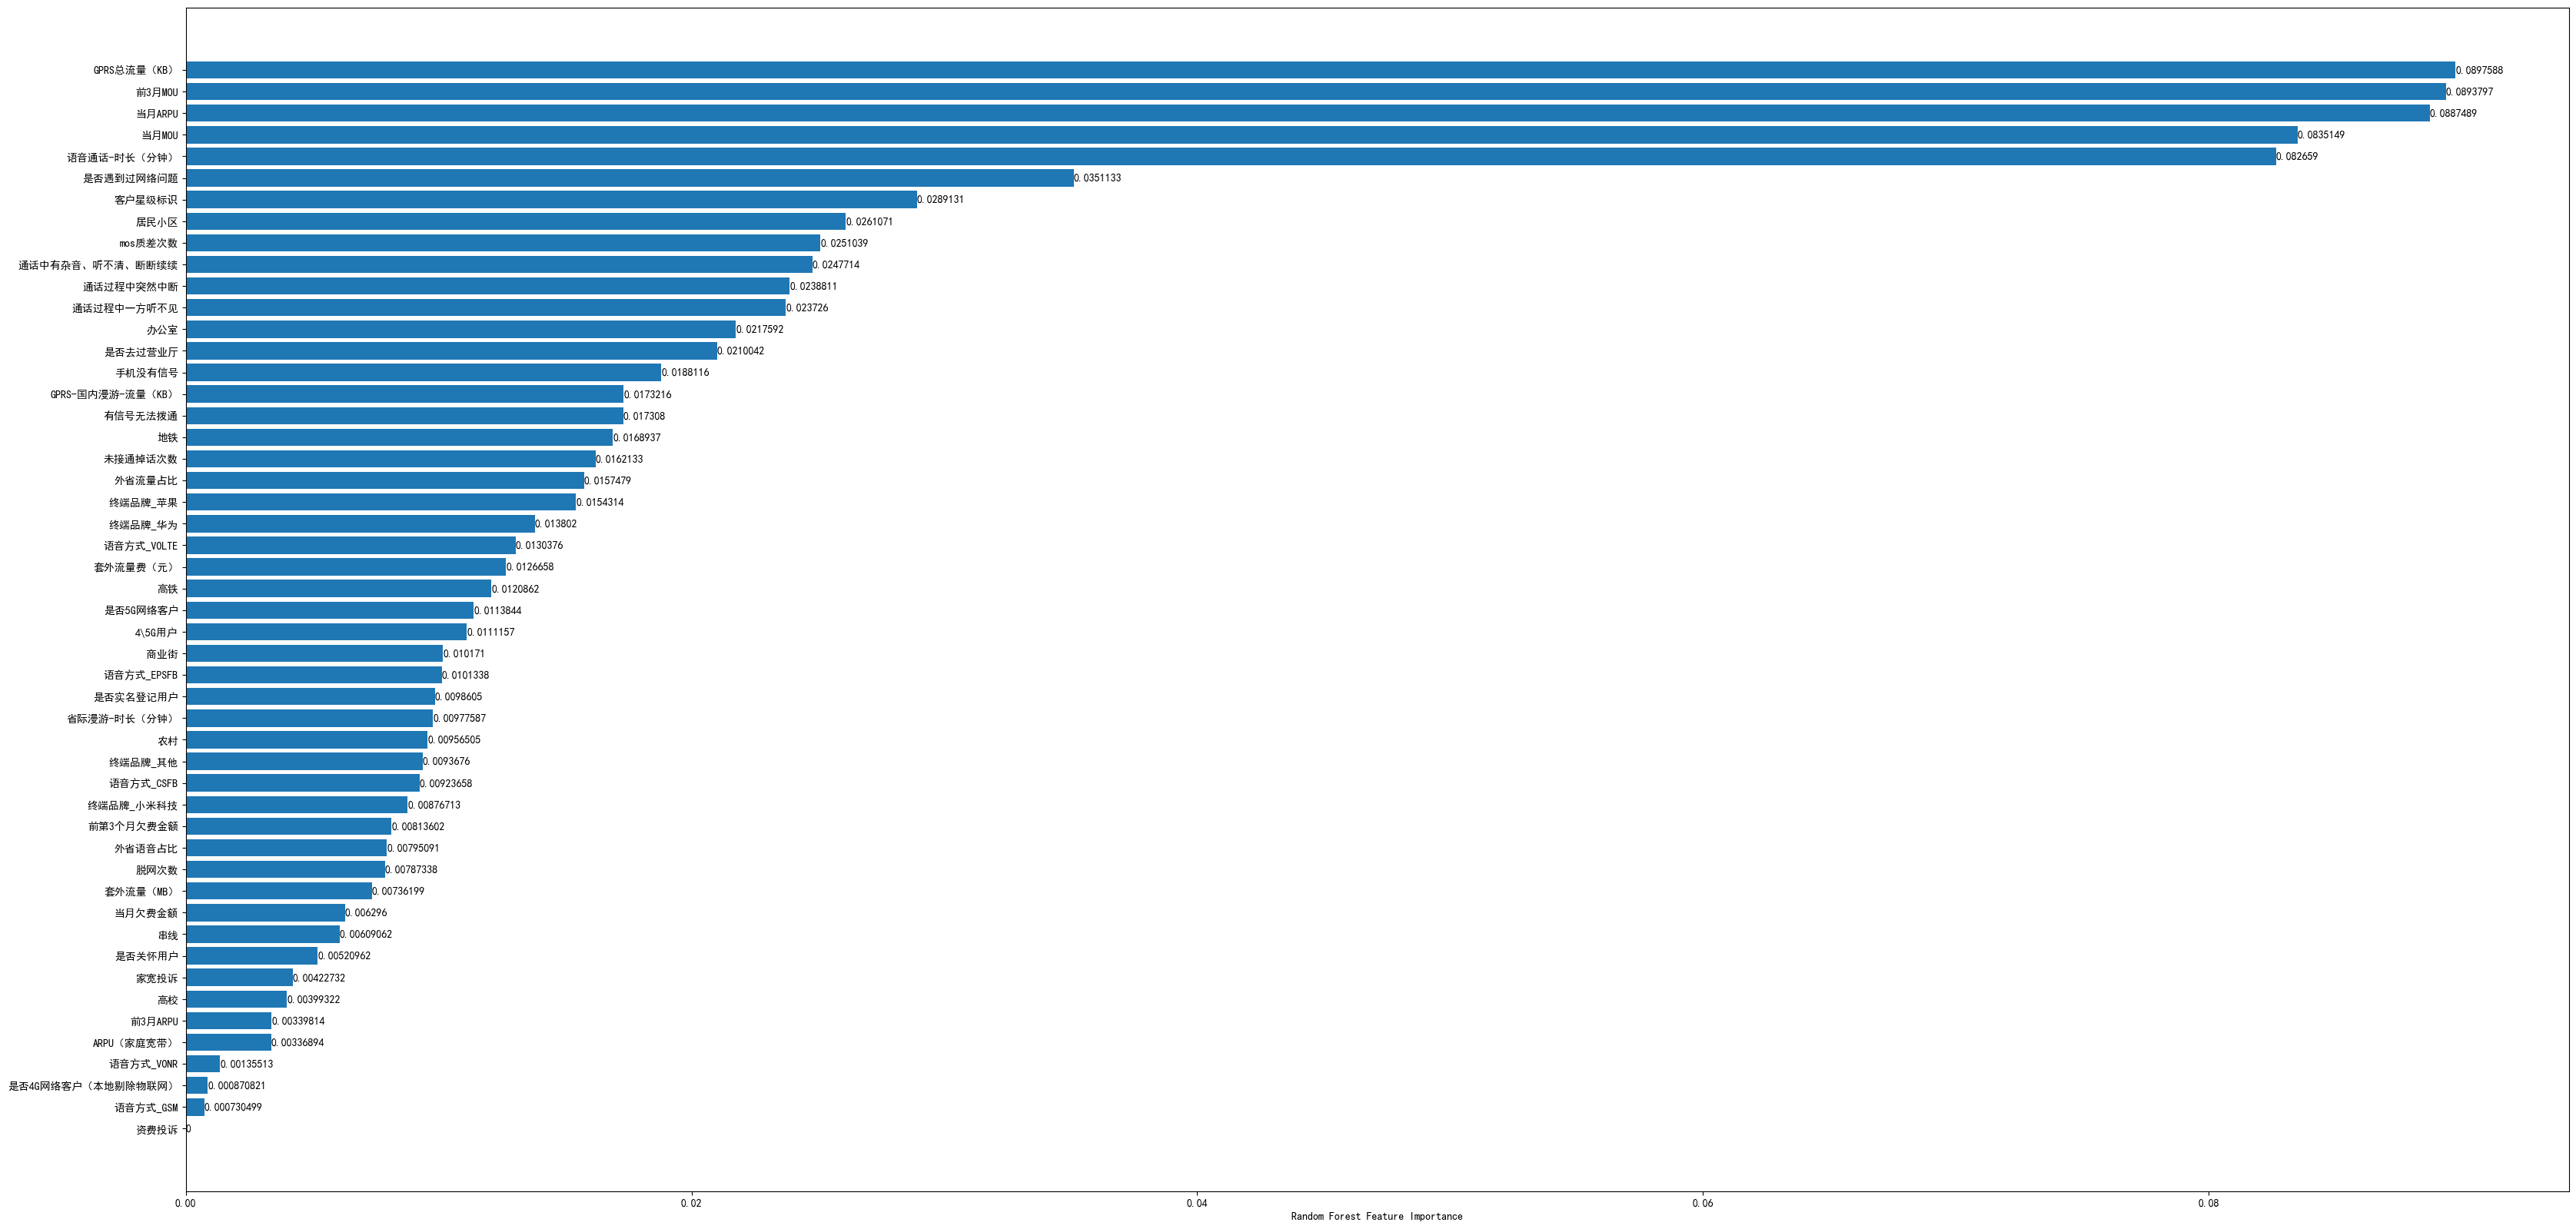

In [48]:
# 画特征重要性排序图
sorted_idx = rfc.feature_importances_.argsort()
plt.figure(figsize=(40,20))
p = plt.barh(rfc.feature_names_in_[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.bar_label(p)
plt.xlabel("Random Forest Feature Importance")

- 特征工程

1. 特征对齐

In [49]:
# 将家宽投诉和资费投诉合并为新的变量“是否投诉”，若家宽投诉和资费投诉均为0，则是否投诉等于0，否则等于1.
train['是否投诉']=train['家宽投诉']+train['资费投诉']
train['是否投诉']=train['是否投诉'].apply(lambda x: 0 if x==0 else 1)

# 生成排除线性相关变量后的数据集train_1
train_1=train.drop(labels=['前3月MOU','语音通话-时长（分钟）',
'外省流量占比','外省语音占比','省际漫游-时长（分钟）',
'前第3个月欠费金额',
'套外流量费（元）',
'前3月ARPU',
'家宽投诉','资费投诉',],axis=1)
# 排除训练集中存在，但测试集中不存在的变量字段
train_1 = train_1.drop(['ARPU（家庭宽带）','当月欠费金额','是否去过营业厅','是否实名登记用户',
'语音方式_CSFB', '语音方式_EPSFB', '语音方式_GSM', '语音方式_VOLTE', '语音方式_VONR'], axis=1)

# 切分训练和验证集
x_train,x_vali,y_train,y_vali = train_test_split(train_1, target.iloc[:,3],test_size=0.3)
for i in range(4):
    rfc = RandomForestClassifier(oob_score=True)
    rfc.fit(x_train, y_train)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train))*100)
    print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)


第0次测试：
Training Accuracy :  100.0
Validation Accuracy :  48.98710865561694
out-of-bagging Accuracy: 50.35535667280864
第1次测试：
Training Accuracy :  100.0
Validation Accuracy :  49.355432780847146
out-of-bagging Accuracy: 52.0400105290866
第2次测试：
Training Accuracy :  100.0
Validation Accuracy :  48.61878453038674
out-of-bagging Accuracy: 50.61858383785207
第3次测试：
Training Accuracy :  100.0
Validation Accuracy :  48.86433394720687
out-of-bagging Accuracy: 51.539878915504076


Text(0.5, 0, 'Random Forest Feature Importance')

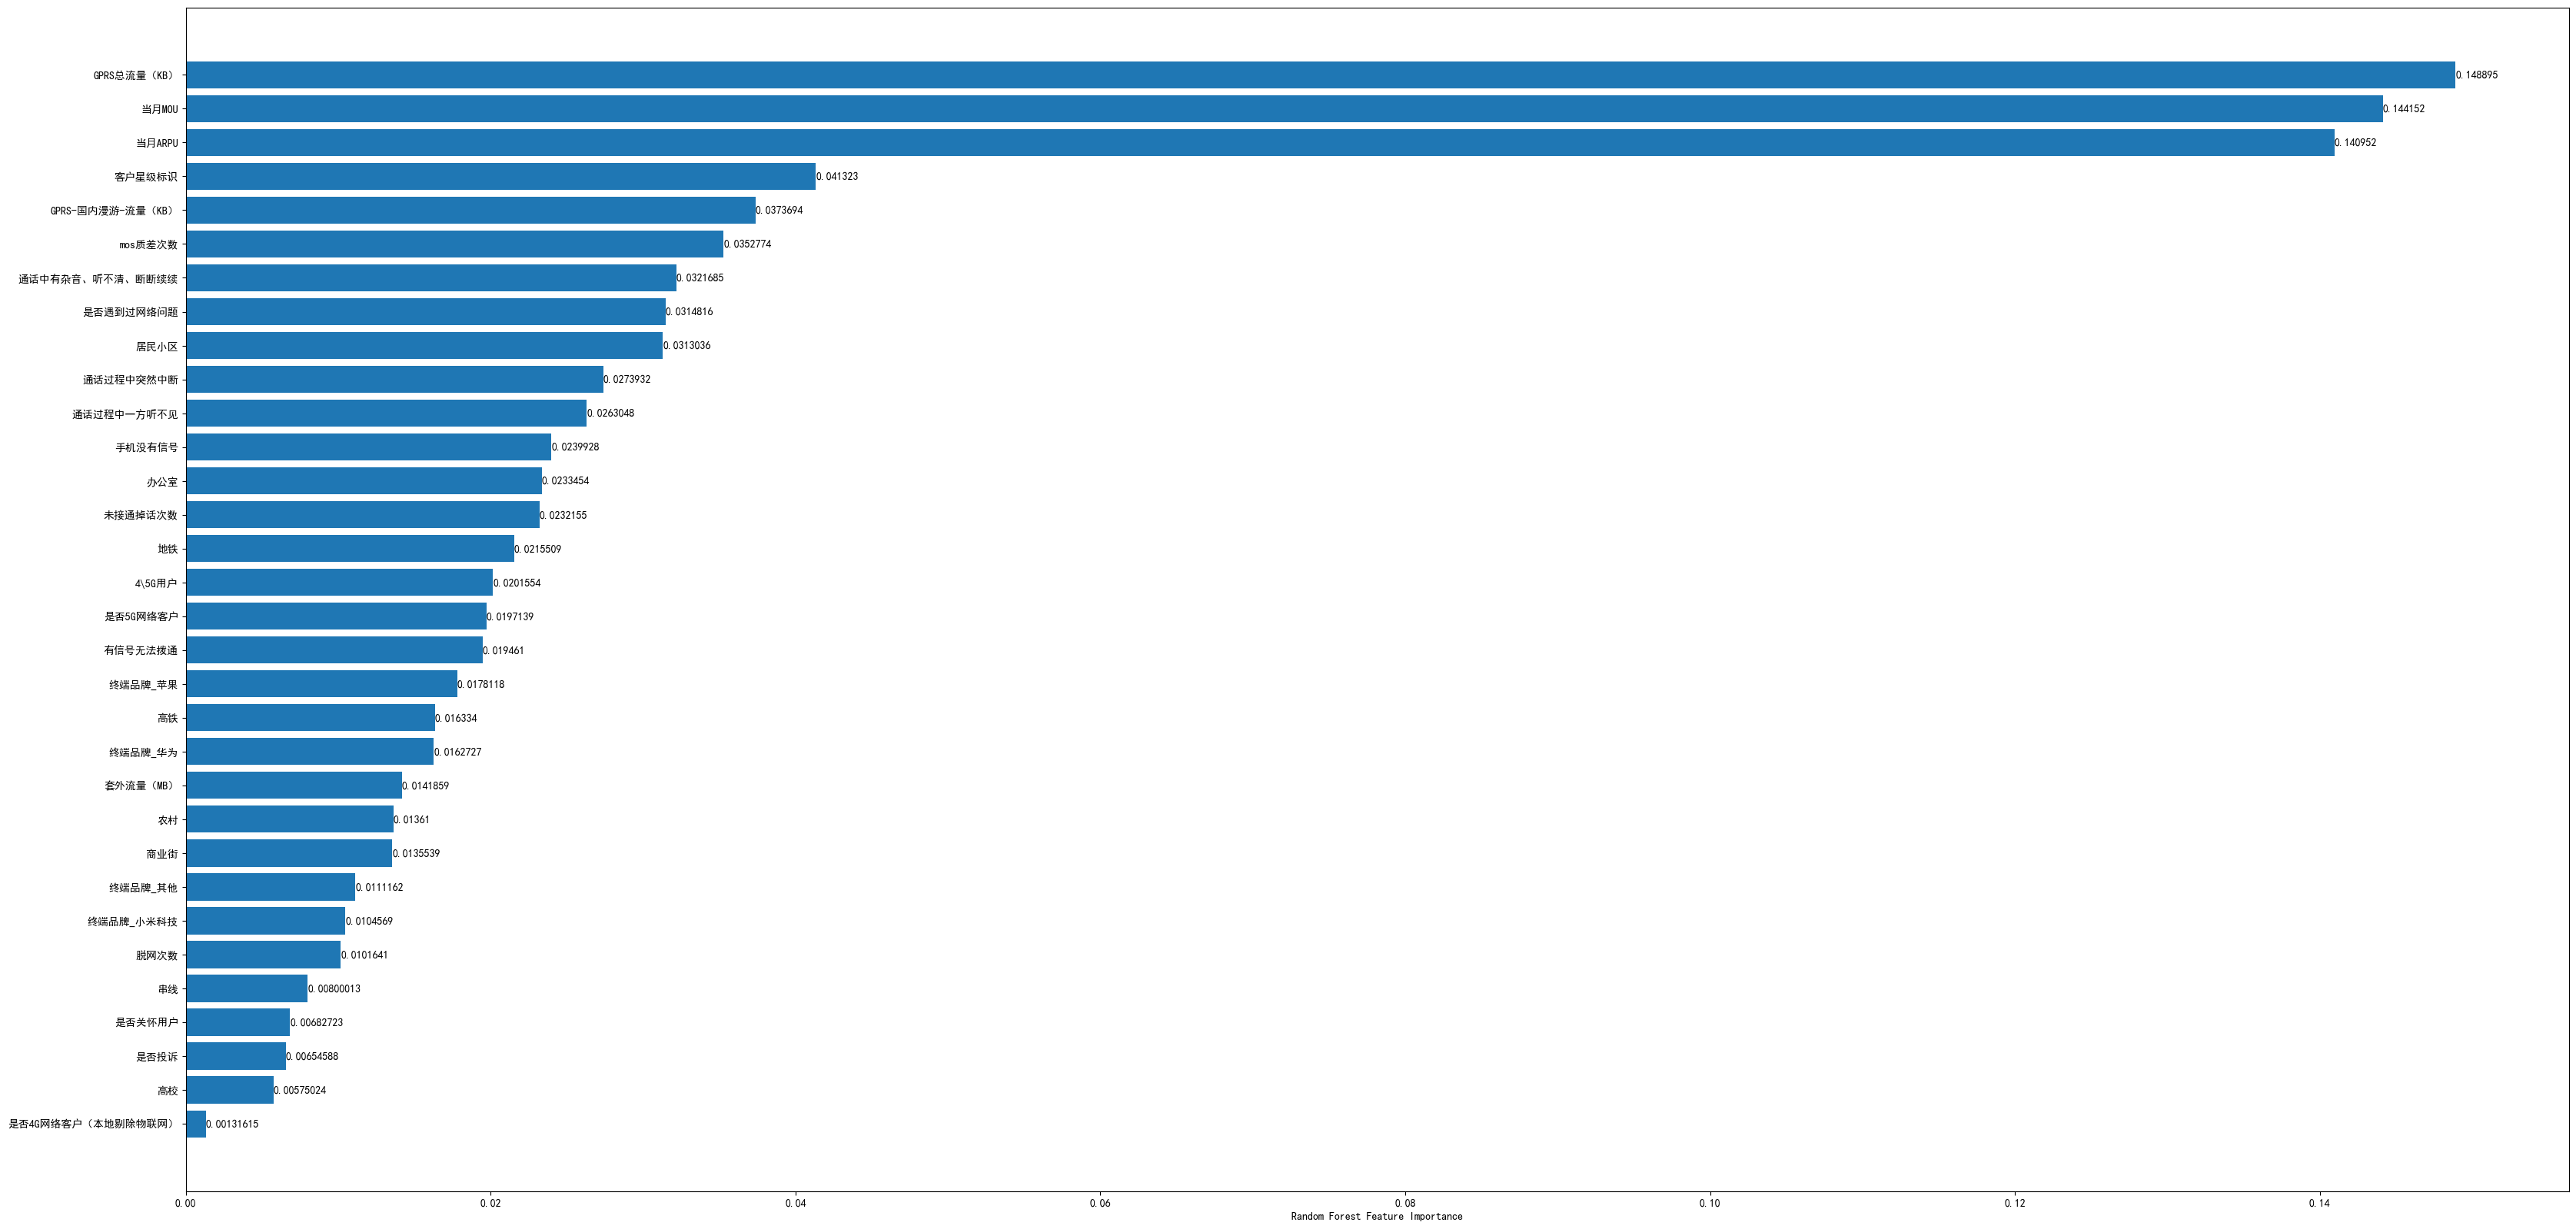

In [50]:
# 画特征重要性排序图
sorted_idx = rfc.feature_importances_.argsort()
plt.figure(figsize=(40,20))
p = plt.barh(rfc.feature_names_in_[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.bar_label(p)
plt.xlabel("Random Forest Feature Importance")

2. 特征衍生

In [51]:
train_2 = train_1.copy()
# 构建三大分项特征
train_2['网络覆盖范围问题']=train_2['居民小区']+train_2['办公室']+train_2['高校']+train_2['商业街']+train_2['地铁']+train_2['农村']+train_2['高铁']
train_2['信号强度问题']=train_2['有信号无法拨通']+train_2['手机没有信号']+train_2['脱网次数']
train_2['通话清晰度问题']=train_2['通话中有杂音、听不清、断断续续']+train_2['通话过程中一方听不见']+train_2['mos质差次数']
train_2['通话稳定性问题']=train_2['通话过程中突然中断']+train_2['串线']+train_2['未接通掉话次数']

# 构建客户特征
colname_sub = ['4\\5G用户','是否关怀用户','是否4G网络客户（本地剔除物联网）','是否5G网络客户','客户星级标识','终端品牌_其他', '终端品牌_华为',
'终端品牌_小米科技', '终端品牌_苹果', '是否投诉']
numcols_sub = ['当月ARPU','套外流量（MB）','当月MOU', 'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）']
aggs = {}
for col in numcols_sub:
    aggs[col] = ['min','mean','max','std']

# 添加新特征
for cate in colname_sub:
    cols_new = []
    cols_new.append(cate)
    for key in aggs.keys():
        cols_new.extend([key + '_' + cate + '_' + stat for stat in aggs[key]])

    new_feature = train_2.groupby(cate).agg(aggs).reset_index()
    new_feature.columns = cols_new
    train_2 = pd.merge(train_2, new_feature, how='left', on=cate)

In [52]:
# 切分训练和验证集
x_train,x_vali,y_train,y_vali = train_test_split(train_2, target.iloc[:,3],test_size=0.3,random_state=0)
for i in range(4):
    rfc = RandomForestClassifier(oob_score=True)
    rfc.fit(x_train, y_train)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train))*100)
    print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)

第0次测试：
Training Accuracy :  99.97367728349566
Validation Accuracy :  48.98710865561694
out-of-bagging Accuracy: 48.460121084495924
第1次测试：
Training Accuracy :  99.97367728349566
Validation Accuracy :  49.04849600982198
out-of-bagging Accuracy: 48.90760726506976
第2次测试：
Training Accuracy :  100.0
Validation Accuracy :  49.04849600982198
out-of-bagging Accuracy: 48.43379836799158
第3次测试：
Training Accuracy :  100.0
Validation Accuracy :  48.98710865561694
out-of-bagging Accuracy: 48.69702553303501


In [53]:
# 剔除重要性小于0.003的变量
sorted_idx = rfc.feature_importances_.argsort()
num = rfc.feature_importances_[sorted_idx]
name = rfc.feature_names_in_[sorted_idx]

sel = {}
drop_list = []
for i,j in zip(name,num):
    if j>0.003:
        sel[i] = j
    else:
        drop_list.append(i)

train_2 = train_2.drop(drop_list,axis=1)

In [54]:
# 切分训练和验证集
x_train,x_vali,y_train,y_vali = train_test_split(train_2, target.iloc[:,3],test_size=0.3,random_state=0)
for i in range(4):
    rfc = RandomForestClassifier(oob_score=True,random_state=0)
    rfc.fit(x_train, y_train)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train))*100)
    print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)

第0次测试：
Training Accuracy :  100.0
Validation Accuracy :  48.7415592387968
out-of-bagging Accuracy: 49.90787049223479
第1次测试：
Training Accuracy :  100.0
Validation Accuracy :  48.7415592387968
out-of-bagging Accuracy: 49.90787049223479
第2次测试：
Training Accuracy :  100.0
Validation Accuracy :  48.7415592387968
out-of-bagging Accuracy: 49.90787049223479
第3次测试：
Training Accuracy :  100.0
Validation Accuracy :  48.7415592387968
out-of-bagging Accuracy: 49.90787049223479


In [55]:
# RFE剔除
rfc = RandomForestClassifier(oob_score=True)
rfe = RFE(estimator=rfc)
rfe.fit(x_train, y_train)
drop_list = rfe.feature_names_in_[~rfe.get_support()]
train_2 = train_2.drop(drop_list,axis=1)
train_2.shape

(5428, 19)

In [56]:
# 切分训练和验证集
x_train,x_vali,y_train,y_vali = train_test_split(train_2, target.iloc[:,3],test_size=0.3,random_state=0)
for i in range(4):
    rfc = RandomForestClassifier(oob_score=True,random_state=0)
    rfc.fit(x_train, y_train)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train))*100)
    print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)

第0次测试：
Training Accuracy :  100.0
Validation Accuracy :  49.66236955187232
out-of-bagging Accuracy: 49.14451171360884
第1次测试：
Training Accuracy :  100.0
Validation Accuracy :  49.66236955187232
out-of-bagging Accuracy: 49.14451171360884
第2次测试：
Training Accuracy :  100.0
Validation Accuracy :  49.66236955187232
out-of-bagging Accuracy: 49.14451171360884
第3次测试：
Training Accuracy :  100.0
Validation Accuracy :  49.66236955187232
out-of-bagging Accuracy: 49.14451171360884


In [57]:
# 网格调参
x_train,x_vali,y_train,y_vali = train_test_split(train_2, target.iloc[:,3],test_size=0.3,random_state=0)

params = {
    'criterion' : ["gini",'entropy'],
    'min_samples_leaf': range(1,11,3),
    'min_samples_split' : range(1,11,3),
    'max_depth': range(5,16,5),
    'max_samples': ['None',0.5,0.7,0.9],
    'max_features': ["sqrt",'log2',2,4,6],
    'n_estimators': range(10,160,70)
    
}

rfc_0 = RandomForestClassifier(random_state=0)
grid_rfc_0 = GridSearchCV(rfc_0, params, n_jobs=-1)
grid_rfc_0.fit(x_train, y_train)

d:\Soft\Python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12600 fits failed out of a total of 28800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7200 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Soft\Python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Soft\Python\lib\site-packages\sklearn\ensemble\_forest.py", line 389, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "d:\Soft\Python\lib\site-packages\sklearn\ensemble\_forest.py", line 125, in _get_n_samples_bootstrap
    raise TypeError(msg.format(type(max_samples)))
TypeError: `max_sample

GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 16, 5),
                         'max_features': ['sqrt', 'log2', 2, 4, 6],
                         'max_samples': ['None', 0.5, 0.7, 0.9],
                         'min_samples_leaf': range(1, 11, 3),
                         'min_samples_split': range(1, 11, 3),
                         'n_estimators': range(10, 160, 70)})

- 预测结果

In [58]:
# 对训练数据按照相同方法生成特征，然后用调整好之后的模型进行预测
# 构建三大分项特征
test['网络覆盖范围问题']=test['居民小区']+test['办公室']+test['高校']+test['商业街']+test['地铁']+test['农村']+test['高铁']
test['信号强度问题']=test['有信号无法拨通']+test['手机没有信号']+test['脱网次数']
test['通话清晰度问题']=test['通话中有杂音、听不清、断断续续']+test['通话过程中一方听不见']+test['mos质差次数']
test['通话稳定性问题']=test['通话过程中突然中断']+test['串线']+test['未接通掉话次数']

# 构建客户特征
colname_sub = ['4\\5G用户','是否关怀用户','是否4G网络客户（本地剔除物联网）','是否5G网络客户','客户星级标识','终端品牌_其他', '终端品牌_华为',
'终端品牌_小米科技', '终端品牌_苹果', '是否投诉']
numcols_sub = ['当月ARPU','套外流量（MB）','当月MOU', 'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）']
aggs = {}
for col in numcols_sub:
    aggs[col] = ['min','mean','max','std']
# 添加新特征
for cate in colname_sub:
    cols_new = []
    cols_new.append(cate)
    for key in aggs.keys():
        cols_new.extend([key + '_' + cate + '_' + stat for stat in aggs[key]])

    new_feature = test.groupby(cate).agg(aggs).reset_index()
    new_feature.columns = cols_new
    test = pd.merge(test, new_feature, how='left', on=cate)

    # 删除无用特征并预测语音整体满意度
useless_cols = set(test.columns.values)-set(train_2.columns.values)
test = test.drop(useless_cols, axis=1)
result = grid_rfc_0.predict(test)
np.savetxt('通话稳定性预测数据.csv', result, delimiter='\n', encoding='utf-8',fmt='%d')